In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
obj = pd.read_pickle('https://surfdrive.surf.nl/files/index.php/s/JdRmiW1qDh9ZJKV/download')

To be able to evaluate the performance of an OLS regression, we have to divide our data into a train and test set. We use 2012-2018 as train data and 2019 as test.

In [3]:
train_data = obj[obj["year"] != 2019]
test_data = obj[obj["year"] == 2019]

The train data is used for the feature selection. Eventually, the features selected will be used to predict the number of crimes for 2019 which can be compared to the actual numbers in the test set. The final performance will be evaluated  by looking at the statistics for this test set. 

The month and year are categorical variables so these have to be converted to dummy variables.

In [4]:
df_months = pd.get_dummies(train_data["month"])
df_years = pd.get_dummies(train_data["year"])

train_data = pd.concat([train_data, df_months, df_years], axis=1)
train_data = train_data.rename(columns={1: "Jan", 2: "Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 
                                        9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"})

#Do the same for the test data
df_months_test = pd.get_dummies(test_data["month"])
df_years_test = pd.get_dummies(test_data["year"])

#test_data also needs the columns 2012,..., 2018 to be able to test but these are 0 everywhere
feature_list = [2012, 2013, 2014, 2015, 2016, 2017, 2018]
zero_data = np.zeros(shape=(len(test_data),len(feature_list)))
d = pd.DataFrame(zero_data, columns=feature_list)

test_data = pd.concat([test_data, df_months_test, df_years_test], axis=1).reset_index()
test_data = pd.concat([test_data, d], axis=1).reset_index()

test_data = test_data.rename(columns={1: "Jan", 2: "Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 
                                        9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"})

In [5]:
# train_data.to_csv('data_final_2.csv')

## Regression 1

Let's have a look at the regressions with the variables, month, year (dummy variables) and population

In [6]:
train_data2 = train_data.dropna()
y_train = train_data2["amount_of_crimes"]
X_train = train_data2[["LSOA population_last_year", "population_last_year", "headcount_last_year", 'prev_month_crimes' , 'GDP_last_year', 'IMD score', "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug",
                "Sep", "Oct", "Nov", "Dec"]]
X_train

,LSOA population_last_year,population_last_year,headcount_last_year,prev_month_crimes,GDP_last_year,IMD score,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1937.0,157840,1238,133.0,22533,49.525,1,0,0,0,0,0,0,0,0,0,0,0
1,1937.0,157840,1238,132.0,22533,49.525,0,1,0,0,0,0,0,0,0,0,0,0
2,1937.0,157840,1238,111.0,22533,49.525,0,0,1,0,0,0,0,0,0,0,0,0
3,1937.0,157840,1238,147.0,22533,49.525,0,0,0,1,0,0,0,0,0,0,0,0
4,1937.0,157840,1238,117.0,22533,49.525,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2764033,1644.0,496043,1007,27.0,25198,16.378,0,0,0,0,0,0,0,1,0,0,0,0
2764034,1644.0,496043,1007,19.0,25198,16.378,0,0,0,0,0,0,0,0,1,0,0,0
2764035,1644.0,496043,1007,17.0,25198,16.378,0,0,0,0,0,0,0,0,0,1,0,0
2764036,1644.0,496043,1007,29.0,25198,16.378,0,0,0,0,0,0,0,0,0,0,1,0


In [7]:
test_data2 = test_data.dropna()
y_test = test_data2["amount_of_crimes"]
X_test = test_data2[["LSOA population_last_year", "LSOA population_last_year", "headcount_last_year", 'prev_month_crimes', 'GDP_last_year', 'IMD score', "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug",
                "Sep", "Oct", "Nov", "Dec"]]
X_test

,LSOA population_last_year,LSOA population_last_year,headcount_last_year,prev_month_crimes,GDP_last_year,IMD score,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2172.0,2172.0,1144,128.0,27735,49.525,1,0,0,0,0,0,0,0,0,0,0,0
1,2172.0,2172.0,1144,134.0,27735,49.525,0,1,0,0,0,0,0,0,0,0,0,0
2,2172.0,2172.0,1144,108.0,27735,49.525,0,0,1,0,0,0,0,0,0,0,0,0
3,2172.0,2172.0,1144,123.0,27735,49.525,0,0,0,1,0,0,0,0,0,0,0,0
4,2172.0,2172.0,1144,107.0,27735,49.525,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338276,1624.0,1624.0,1021,14.0,26113,16.378,0,0,0,0,0,0,0,1,0,0,0,0
338277,1624.0,1624.0,1021,13.0,26113,16.378,0,0,0,0,0,0,0,0,1,0,0,0
338278,1624.0,1624.0,1021,11.0,26113,16.378,0,0,0,0,0,0,0,0,0,1,0,0
338279,1624.0,1624.0,1021,18.0,26113,16.378,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
model = LinearRegression()

In [9]:
estimator_1 = model.fit(X_train, y_train)

In [10]:
predictions = estimator_1.predict(X_test)

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('Root Mean Squared Error:', mean_squared_error(y_test,predictions)**(1/2))
print('R2_score:', r2_score(y_test,predictions))

Root Mean Squared Error: 7.505092876477775
R2_score: 0.9021511738779181


In [12]:
RMSE_OLS = mean_squared_error(y_test,predictions)**(1/2)

In [13]:
NRMSE_OLS = RMSE_OLS / y_test.mean()
NRMSE_OLS

0.47534114388086623

In [14]:
NRMSE_OLS = RMSE_OLS / (y_test.max() - y_test.min())
NRMSE_OLS

0.006269918860883688

In [15]:
y_test.max(), y_test.min()

(1198, 1)

Linear Regression with sm models


In [16]:
import numpy as np
import statsmodels.api as sm

# Fit and summarize OLS model

model = sm.OLS(y_train, X_train)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       amount_of_crimes   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                 1.123e+06
Date:                Thu, 07 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:09:24   Log-Likelihood:            -8.1556e+06
No. Observations:             2425769   AIC:                         1.631e+07
Df Residuals:                 2425751   BIC:                         1.631e+07
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LSOA population_last_year     0.0009   1.32e-05     69.378      0.000       0.001       0.001
population_last_year      -2.029e-07   2.57e-08     -7.904      0.000   -2.53e-07   -1.53e-07
headcount_last_year        2.713e-06    4.2e-07      6.455      0.000    1.89e-06    3.54e-06
prev_month_crimes             0.9312      0.000   3927.671      0.000       0.931       0.932
GDP_last_year              1.134e-06   3.67e-08     30.848      0.000    1.06e-06    1.21e-06
IMD score                     0.0301      0.000     96.630      0.000       0.029       0.031
Jan                          -1.0389      0.027    -37.963      0.000      -1.093      -0.985
Feb                          -1.9621      0.027    -71.764      0.000      -2.016      -1.909
Mar                           0.3442      0.027     12.593      0.000       0.291       0.398
Apr                          -1.4777      0.027    -54.186      0.000      -1.531      -1.424
May                          -0.3152      0.027    -11.561      0.000      -0.369      -0.262
Jun                          -1.1957      0.027    -43.899      0.000      -1.249      -1.142
Jul                          -0.1540      0.027     -5.656      0.000      -0.207      -0.101
Aug                          -1.6627      0.027    -61.115      0.000      -1.716      -1.609
Sep                          -2.0858      0.027    -76.585      0.000      -2.139      -2.032
Oct                          -0.4696      0.027    -17.226      0.000      -0.523      -0.416
Nov                          -2.1864      0.027    -80.232      0.000      -2.240      -2.133
Dec                          -2.0798      0.027    -76.156      0.000      -2.133      -2.026
==============================================================================
Omnibus:                  1495019.244   Durbin-Watson:                   2.768
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1268700631.714
Skew:                           1.558   Prob(JB):                         0.00
Kurtosis:                     114.993   Cond. No.                     5.36e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
prediction = res.predict(X_test)
df_pred = pd.DataFrame({'prediction': prediction, 'real': y_test})
# df_pred['error'] = np.log2(abs(df_pred['prediction'] - df_pred['real']))
df_pred['error'] = abs(df_pred['prediction'] - df_pred['real'])
df_pred

,prediction,real,error
0,121.671571,134,12.328429
1,126.335549,108,18.335549
2,104.430592,123,18.569408
3,116.576736,107,9.576736
4,102.840004,111,8.159996
...,...,...,...
338276,13.388780,13,0.388780
338277,12.034397,11,1.034397
338278,11.788265,18,6.211735
338279,16.589867,14,2.589867


In [18]:
import seaborn as sns

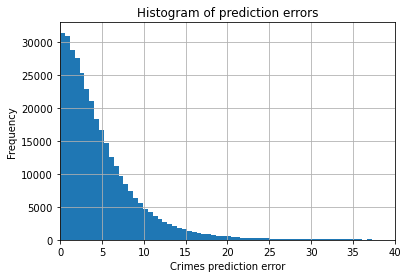

In [19]:
df_pred['error'].hist(bins = 1000)
plt.title('Histogram of prediction errors')
plt.xlabel('Crimes prediction error')
plt.ylabel('Frequency')
plt.xlim([0, 40]);

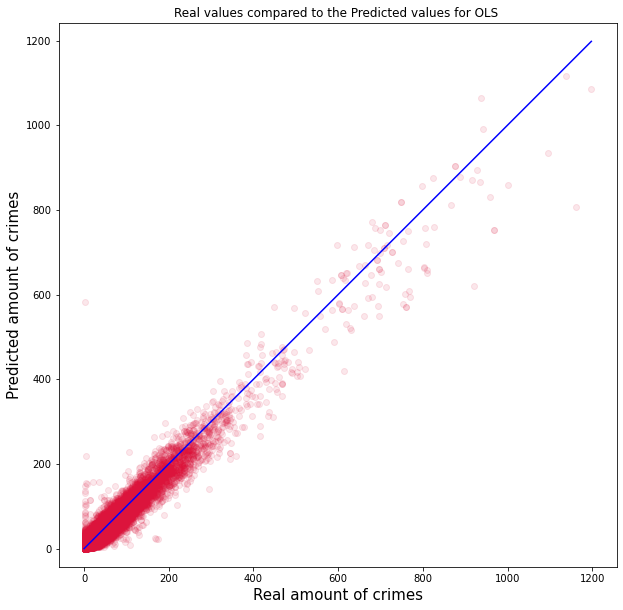

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(df_pred['real'], df_pred['prediction'], c='crimson', alpha = 0.1)

p1 = max(max(df_pred['prediction']), max(df_pred['real']))
p2 = min(min(df_pred['prediction']), min(df_pred['real']))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Real values compared to the Predicted values for OLS ')
plt.xlabel('Real amount of crimes', fontsize=15)
plt.ylabel('Predicted amount of crimes', fontsize=15)
plt.axis('equal');

Making the top 10's and low 10's

In [21]:
#Making top table (Low table change 'ascending = True'):

test_data_forecasted = test_data2.copy()
test_data_forecasted['predicted_amount_of_crimes'] = prediction
top_5_df = test_data_forecasted[['LSOA name', 'predicted_amount_of_crimes', 'LSOA population_last_year']]
top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_predicted = top_5_df.sort_values('predicted_amount_of_crimes_per_head', ascending=False).reset_index()

test_data_forecasted = test_data2.copy()
top_5_df = test_data_forecasted[['LSOA name', 'amount_of_crimes', 'LSOA population_last_year']]
top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_real = top_5_df.sort_values('amount_of_crimes_per_head', ascending=False).reset_index()

top_df = top_5_df_predicted
top_df['real LSOA name'] = top_5_df_real['LSOA name']
top_df['amount_of_crimes'] = top_5_df_real['amount_of_crimes']
top_df['amount_of_crimes_per_head'] = top_5_df_real['amount_of_crimes_per_head']
del top_df['LSOA population_last_year']

top_df.head(10)

C:\Users\20203203\AppData\Local\Temp/ipykernel_4056/1477530028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
C:\Users\20203203\AppData\Local\Temp/ipykernel_4056/1477530028.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']


,LSOA name,predicted_amount_of_crimes,predicted_amount_of_crimes_per_head,real LSOA name,amount_of_crimes,amount_of_crimes_per_head
0,Westminster 013E,834.181755,0.594147,City of London 001F,720.750000,0.640667
1,City of London 001F,668.077091,0.593846,Westminster 013E,897.166667,0.639008
2,Westminster 018A,824.395645,0.439678,Westminster 018A,874.750000,0.466533
3,Manchester 054C,560.146570,0.354299,Manchester 054C,575.333333,0.363905
4,Birmingham 138A,431.476034,0.307977,Birmingham 138A,465.166667,0.332025
5,Westminster 018C,588.892908,0.299234,Westminster 018C,633.166667,0.321731
6,Westminster 013B,703.019861,0.253523,Westminster 013B,742.166667,0.267640
7,Westminster 018B,285.317610,0.213721,Westminster 018B,309.833333,0.232085
8,Gloucester 004F,221.803990,0.183461,Gloucester 004F,234.916667,0.194307
9,Newcastle upon Tyne 024G,420.888276,0.183314,Kingston upon Hull 029E,313.500000,0.193042
